In [9]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import sys,os
import pickle
from eknot_utils import EventNode,NodeParams
from utils import loadPickle,triHits,norm2,printTopWords,coHits,lexRank,norm1
from eknot_utils import *
from time import time

[resDocInd,tweetsObj,tweetsObjDedup,tweetsScore]= loadPickle('../output/summary_20160207_0213_70_18.pickle')
[Xs,vects,DT,ind2obj] = loadPickle('../data/20160207_0213.pickle')
rootParams,rootNodeDescriptor = loadPickle('../output/plsa_20160207_0213_70.pickle')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
i = 18
window = 7
t0 = time()
Pw_zs = rootNodeDescriptor.Pw_zs
Pe_z = Pw_zs[1][:,i]
evocab = vects[5].get_feature_names()
vocab = vects[0].get_feature_names()

ent_ind,ents = getEntInd(evocab,Pe_z,topK)

print( "entscore in "+str(time() - t0))
t0 = time()

newsObj = [ind2obj[n] for n in resDocInd]
XN,XEn,NEb,sentencesIn,sentencesInObj,ent_text_n = getNewsContext(newsObj,ent_ind,ents,vocab,window)
print( "get news Context in "+str(time() - t0))
print len(newsObj),len(sentencesIn),len(set(sentencesIn))
t0 = time()

XT,XEt,TEb,tweetsIn,tweetsInObj,ent_text_t = getTweetContext(tweetsObjDedup,ent_ind,ents,vocab,window)
print( "get tweet Context in "+str(time() - t0))

print len(tweetsObjDedup),len(tweetsIn),len(set(tweetsIn))
print XEn.shape,Pe_z.shape

entscore in 0.0537939071655
get news Context in 0.616780996323
12 282 207
append in 0.352433919907
vectorize in 2.01333904266
ents append + vec in 0.249597072601
get tweet Context in 2.65053510666
2105 2104 2104
(1000, 15042) (4947,)


In [291]:
_XEn = XEn
_XEt = XEt
_NEb = NEb
_TEb = TEb

In [295]:

#####
rows = []
interestedEnts = ['tin_can_other_|','tower_block_other_|']
#interestedEnts = ents[4:]
for e in interestedEnts:
    rows.append(ent_ind[e])
rows = np.array(rows)
#rows = np.array([10,33,34,40])
XEn = _XEn[rows,:]
XEt = _XEt[rows,:]
NEb = _NEb[:,rows]
TEb = _TEb[:,rows]
#####

topK = 100 # ent used

t0 = time()

newsScore = XN.dot(Pw_zs[0][:,i])

tweetsScore = XT.dot(Pw_zs[0][:,i])
#tweetsScore = []
#for t in tweetsInObj:
#    tweetsScore.append(float(t.pop))
#tweetsScore = np.array(tweetsScore)

print( "init score in "+str(time() - t0))
t0 = time()

NE_ = XN.dot(XEn.T) #.multiply(NEb)
TE_ = XT.dot(XEt.T) #.multiply(TEb)

##### weight by pop
TE_indptr = TE_.indptr
TE_data = TE_.data
for (XTid,t) in enumerate(tweetsInObj):
    st = TE_indptr[XTid]
    en = TE_indptr[XTid+1]
    TE_data[st:en]*=float(t.pop)
#####

NE,EN = normBypartite(NE_)
TE,ET = normBypartite(TE_)
print( "graph constr in "+str(time() - t0))
t0 = time()

#nScore, tScore = triHits(newsScore, tweetsScore, NE, EN, TE, ET, 1, 1, 5)
#print( "trihits in "+str(time() - t0))



########### params ############
passes = 100
wN = 0.9
wT = 0.9
######### tri hits #########
nScore, tScore = triHits(newsScore, tweetsScore, NE, EN, TE, ET, wN,wT, passes)
#nScore, tScore = triHits(np.ones(newsScore.shape), np.ones(tweetsScore.shape), NE, EN, TE, ET, 1, 1, 50)
print np.linalg.norm(norm2(newsScore)[:10] - nScore[:10])
#print "========="
#kSummary=5
#printSummary(norm2(newsScore),norm2(tweetsScore),sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,kSummary)
#print "*****"
#printSummary(nScore,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,kSummary)

######## tri_n ################
entsScore = XEn.dot(Pw_zs[0][:,i])
#printRankedEnt(entsScore,ents,100,DISPLAY=True)
nScore_tri_n, eScore = coHits(newsScore, entsScore, NE, EN, wN, wT, passes)
#printSummary(nScore_tri_n,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,5)
#########################

############ lexrank ####################
NN = normalize(XN.dot(XN.T),axis=1,norm='l1')
nScore_lex = lexRank(newsScore,NN,passes=200)
#printSummary(nScore_lex,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,10)
####################################

#############co-hits#######################
NT = normalize(XN.dot(XT.T),axis=1,norm='l1')
TN = normalize(XT.dot(XN.T),axis=1,norm='l1')
nScore_co,tScore_co = coHits(newsScore,tweetsScore,NT,TN,wN,wT,passes)
#printSummary(nScore_co,tScore_co,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,10)
#########################################

################# rank ents ####################
_res1 = printRankedEnt(NE.T.dot(newsScore),ents,topK)
res1 = printRankedEnt(NE.T.dot(nScore),ents,topK)
res2 = printRankedEnt(NE.T.dot(nScore_lex),ents,topK)
res3 = printRankedEnt(NE.T.dot(nScore_co),ents,topK)
res4 = printRankedEnt(NE.T.dot(nScore_tri_n),ents,topK)

# _res2 = printRankedEnt(TE.T.dot(tweetsScore),ents,100)
# res2 = printRankedEnt(TE.T.dot(tScore),ents,100)

for e in ents[:20]:
    #print res1[e],_res1[e],res2[e],_res2[e],'>|<',res1[e]-_res1[e],res2[e]-_res2[e], res2[e] - res1[e],e
    print res1[e] - res2[e],res3[e] - res2[e],res1[e]-res4[e],res3[e]-res4[e],\
        '\t|',res1[e],res2[e],res3[e],res4[e],_res1[e],\
        '\t|',res1[e]-_res1[e],res2[e]-_res1[e],res3[e]-_res1[e],res4[e]-_res1[e],\
        '\t|',res2[e] - res4[e],e

print "##############"        

printRankedEnt(NE.T.dot(nScore),ents,100,DISPLAY=True)

init score in 0.00117707252502
graph constr in 0.0275399684906
==n converge 6 2.24108123511e-10
0.229888427778
==n converge 23 6.31045376525e-10
==e converge 10 9.29107710004e-10
0 0 0 0 	| -1 -1 -1 -1 -1 	| 0 0 0 0 	| 0 taiwan_loc_|
0 0 0 0 	| 1 1 1 1 1 	| 0 0 0 0 	| 0 tainan_loc_|


KeyError: u'chinese_new_year_other_|'

In [296]:
from eknot_utils import printSummaryOne
kSummary = int(np.log(len(set(sentencesIn))))
print kSummary
b=0.25
print '########### lex rank ##############'
#printSummary(nScore_lex,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,kSummary)
printSummaryOne(nScore_lex,sentencesIn,sentencesInObj,XN,kSummary,b)

print '########### tri hits ##############'
#printSummary(nScore,tScore,sentencesIn,sentencesInObj,tweetsIn,tweetsInObj,kSummary)
printSummaryOne(nScore,sentencesIn,sentencesInObj,XN,kSummary,b)
print '##### tweets ####'
printSummaryOne(tScore,tweetsIn,tweetsInObj,XT,2*kSummary,b)

5
########### lex rank ##############
 saturday's quake killed at least 38 people in  tainan city in southern  taiwan, all but two of them in the collapse of the 17-story building.
 more than 100 people are believed to be still buried in the collapsed building from a disaster that struck during the most important  family holiday in the  chinese calendar -- the  lunar new year holiday.
 earthquakes frequently  rattle  taiwan, but most are minor and cause little or no damage, though a  magnitude-7.6 quake in central  taiwan in 1999 killed more than 2,300 people.
 survivors pulled out from building 2 days after  taiwan quake
 rescuers said tsao was found under the body of her husband, who had shielded her from a collapsed  beam,  taiwan's government-run  central news agency reported.
########### tri hits ##############
 4 survivors rescued from collapsed  taiwan  apartment building as rescue workers find  tin cans built into walls
 images that have surfaced of  tin cans believed to be use

In [166]:
################# rank words ####################
wtopK=len(vocab)
_res1 = printRankedEnt(XN.T.dot(newsScore),vocab,wtopK)
res1 = printRankedEnt(XN.T.dot(nScore),vocab,wtopK)
res2 = printRankedEnt(XN.T.dot(nScore_lex),vocab,wtopK)
res3 = printRankedEnt(XN.T.dot(nScore_co),vocab,wtopK)
res4 = printRankedEnt(XN.T.dot(nScore_tri_n),vocab,wtopK)

# _res2 = printRankedEnt(TE.T.dot(tweetsScore),ents,100)
# res2 = printRankedEnt(TE.T.dot(tScore),ents,100)
print i
for k in Pw_zs[0][:,i].argsort()[::-1][:topK]:
    e = vocab[k]
    #print res1[e],_res1[e],res2[e],_res2[e],'>|<',res1[e]-_res1[e],res2[e]-_res2[e], res2[e] - res1[e],e
    print res1[e] - res2[e],res3[e] - res2[e],res1[e]-res4[e],res3[e]-res4[e],\
        '\t|',res1[e],res2[e],res3[e],res4[e],_res1[e],\
        '\t|',res1[e]-_res1[e],res2[e]-_res1[e],res3[e]-_res1[e],res4[e]-_res1[e],\
        '\t|',res2[e] - res4[e],e

print "##############"        
printRankedEnt(XN.T.dot(nScore),vocab,topK,DISPLAY=True)

18
0 0 0 0 	| 13351 13351 13351 13351 13351 	| 0 0 0 0 	| 0 taiwan
-1 0 -1 0 	| 10725 10726 10726 10726 10726 	| -1 0 0 0 	| 0 quake
1 0 1 0 	| 2278 2277 2277 2277 2277 	| 1 0 0 0 	| 0 building
1 1 0 0 	| 13345 13344 13345 13345 13345 	| 0 -1 0 0 	| -1 tainan
-2 0 -2 0 	| 3013 3015 3015 3015 3015 	| -2 0 0 0 	| 0 collapsed
36 -4 24 -16 	| 8044 8008 8004 8020 8012 	| 32 -4 -8 8 	| -12 lin
15 12 2 -1 	| 4656 4641 4653 4654 4654 	| 2 -13 -1 0 	| -13 earthquake
-19 -32 -19 -32 	| 6642 6661 6629 6661 6660 	| -18 1 -31 1 	| 0 holiday
11 3 12 4 	| 11283 11272 11275 11271 11268 	| 15 4 7 3 	| 1 rescue
12 6 3 -3 	| 3299 3287 3293 3296 3288 	| 11 -1 5 8 	| -9 construction
0 3 6 9 	| 4496 4496 4499 4490 4500 	| -4 -4 -1 -10 	| 6 dragon
3 5 2 4 	| 13229 13226 13231 13227 13228 	| 1 -2 3 -1 	| -1 survivors
25 24 13 12 	| 13745 13720 13744 13732 13732 	| 13 -12 12 0 	| -12 toppled
-22 -33 -20 -31 	| 8218 8240 8207 8238 8233 	| -15 7 -26 5 	| 2 lunar
-6 1 8 15 	| 11275 11281 11282 11267 11277 	| -2 4

{u'100': 48,
 u'113': 75,
 u'17': 167,
 u'1999': 215,
 u'2,300': 204,
 u'4': 325,
 u'6': 398,
 u'6.4': 391,
 u'8': 440,
 u'according': 550,
 u'agency': 805,
 u'apartment': 1197,
 u'authorities': 1440,
 u'believed': 1774,
 u'body': 1949,
 u'building': 2278,
 u'buildings': 2229,
 u'built': 2234,
 u'buried': 2220,
 u'calendar': 2293,
 u'cans': 2394,
 u'cause': 2513,
 u'central': 2609,
 u'chinese': 2689,
 u'city': 2838,
 u'cna': 2880,
 u'cnn': 2875,
 u'collapse': 3008,
 u'collapsed': 3013,
 u'complex': 3153,
 u'construction': 3299,
 u'damage': 3719,
 u'days': 3825,
 u'dead': 3779,
 u'death': 3803,
 u'debris': 3777,
 u'developer': 4119,
 u'disaster': 4202,
 u'dragon': 4496,
 u'earlier': 4572,
 u'earthquake': 4656,
 u'earthquakes': 4633,
 u'family': 5295,
 u'frequently': 5824,
 u'girl': 6011,
 u'golden': 6076,
 u'government': 6060,
 u'high-rise': 6568,
 u'holiday': 6642,
 u'hours': 6695,
 u'husband': 6773,
 u'important': 6868,
 u'killed': 7661,
 u'lin': 8044,
 u'little': 8050,
 u'lunar': 821

875


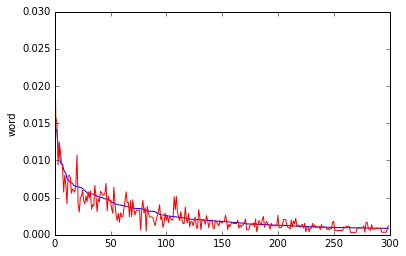

1.65486930951	earthquake
1.50194118528	lin
1.43201868136	toppled
1.32387123742	taiwan
1.18255998574	developer
1.16672610139	apartment
1.15799138385	survivors
1.15060594956	rescue
1.10375105071	quake
1.09653429806	construction
1.08988201076	building
1.05349663877	tainan
1.0319454128	missing
0.999455700102	dragon
0.967405220831	collapsed
0.951793849224	rescuers
0.895210120242	rescued
0.871767907582	struck
0.783800663943	lunar
0.75256227134	holiday
13351 13351 0.0337792671381 taiwan
10726 10727 0.0211504320904 quake
2277 2279 0.0186399808117 building
13345 13348 0.0182837100875 tainan
3016 3020 0.010500092776 collapsed
8065 8070 0.00967306421637 lin
4654 4660 0.00784449580039 earthquake
6668 6675 0.00773736823383 holiday
11296 11304 0.00751551894838 rescue
3324 3333 0.00721243079166 construction
4522 4532 0.00690141213377 dragon
13224 13235 0.00680266961007 survivors
13743 13755 0.00663405956373 toppled
8247 8260 0.00648801865582 lunar
11291 11305 0.00626652889076 rescued
8767 8782 0.0062

In [287]:
kplot=300
kprint = 20
w_lex = normalize(XN,axis=1,norm='l1').T.dot(nScore_lex)
w_tri = normalize(XN,axis=1,norm='l1').T.dot(nScore)
N = min(sum(w_lex!=0),sum(w_tri!=0))
print N
wind = w_lex.argsort()[::-1][:kplot]
w_lex_ = np.array([w_lex[k] for k in wind])
w_tri_ = np.array([w_tri[k] for k in wind])


# rate = w_tri_/w_lex_
# #ate = np.array([w_tri_[k]/w_lex_[k] if w_tri_[k] /w_lex_[k]>1 else w_lex_[k]/w_tri_[k] for k in range(len(w_tri_))])
# rind = rate.argsort()[::-1][:50]
# for k in rind:    
#     print k,w_tri_[k]/w_lex_[k],vocab[wind[k]]
plt.plot(range(len(wind)),w_lex_,'b',w_tri_,'r')
#plt.plot(range(len(wind)),np.log(w_lex_),'b',np.log(w_tri_),'r')
plt.ylabel('word')

fig = plt.gcf()
fig.savefig('/home/jwang112/Dropbox/linux_buffer/figs/word.png',bbox_inches='tight')
plt.show()

indsmall=[]
for wi in Pw_zs[0][:,i].argsort()[::-1][:kprint]:
    indsmall.append(wi)
indsmall = np.array(indsmall)    
XNsmall = XN[:,indsmall]

w_lex_small = w_lex[indsmall]
w_tri_small = w_tri[indsmall]
windsmall = w_lex_small.argsort()[::-1]
w_lex_small_ = np.array([w_lex_small[k] for k in windsmall])
w_tri_small_ = np.array([w_tri_small[k] for k in windsmall])

rate = w_tri_small_/w_lex_small_
#ate = np.array([w_tri_[k]/w_lex_[k] if w_tri_[k] /w_lex_[k]>1 else w_lex_[k]/w_tri_[k] for k in range(len(w_tri_))])
rind = rate.argsort()[::-1]
for k in rind:    
    #print k,w_tri_small_[k]/w_lex_small_[k],vocab[indsmall[windsmall[k]]]
    print str(w_tri_small_[k]/w_lex_small_[k])+'\t'+vocab[indsmall[windsmall[k]]]
    

i=18
res0 = printRankedEnt(Pw_zs[0][:,i],vocab,20,DISPLAY=True)

20 1.65486930951 earthquake
0 1.32387123742 taiwan
5 1.15799138385 survivors
13 1.10739897989 earthquakes
1 1.10375105071 quake
2 1.08988201076 building
14 1.08302054739 rattle
12 1.06161770055 frequently
19 1.05855205686 collapse
4 1.05349663877 tainan
6 1.02590745407 pulled
7 0.967405220831 collapsed
25 0.96287457208 killed
9 0.946858631915 city
17 0.902757790806 reported
28 0.895210120242 rescued
16 0.894510501148 central
18 0.871767907582 struck
24 0.822149197736 new
10 0.804434653892 monday
15 0.799553609758 year-old
3 0.790133573965 people
29 0.783800663943 lunar
23 0.779411046373 year
26 0.75256227134 holiday
27 0.703409456053 sunday
8 0.653031930708 believed
21 0.627533438133 husband
11 0.554741662866 family
22 0.476150110897 body


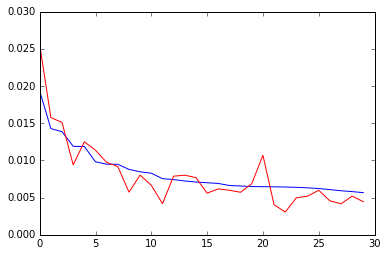

In [255]:
#normalize(XN,axis=1,norm='l1')
#sum(w_lex),sum(w_tri)
rate = w_tri_/w_lex_
rind = rate.argsort()[::-1][:50]
for k in rind:    
    print k,w_tri_[k]/w_lex_[k],vocab[wind[k]]
plt.plot(range(len(wind)),w_lex_,'b',w_tri_,'r')

In [261]:
#w_tri[8070]/w_lex[8070]
w_lex.argsort()[::-1][:100]

array([13351, 10727,  2279,  9903, 13348, 13235, 10663,  3020,  1817,
        2847,  8858,  5348,  5855,  4662, 10884, 14969,  2625, 11271,
       13022,  3019,  4660,  6832,  2037, 14968,  9142,  7678,  6675,
       13148, 11305,  8260,  8782,  9150, 11818, 13973, 13879,  6762,
        3838,  2280,   124, 11307,   857,  1211,  3173, 12955,  3333,
       11304, 13755,  3845,   190,  6113,  4532,  6068,   266, 11663,
         264,  2771, 11190, 12184,  8576,  6137,  6958,  2382,   454,
        4169,  8070,  6607, 14873,  3873,  2282,  1756, 12619,  2573,
        4283,  8308,  8113,   269,  3781,  1374,  2958, 10299,   511,
       14711, 14928,   386,  8749, 14704,  4607,  2389, 12811,  7122,
       14076,  6141,  3782,   461,  3861,  3735,   644, 14971,  7861,  8306])

125
1.25407754454	taipei_loc
1.21059312921	tin_can_other
1.12917235776	quake_(video_game)_other
1.12250056426	earthquake_other
1.10901701914	taiwan_loc
1.0601749804	apartment_other
1.03935975692	rubble_other
1.03510430609	moment_magnitude_scale_other
1.03019070192	tower_block_other
0.995932437614	richter_magnitude_scale_other
0.972111594861	tainan_loc
0.963914826726	survivor_(band)_org
0.953102628387	channel_newsasia_org
0.940641552354	ma_ying-jeou_per
0.892359569888	korean_central_news_agency_other
0.81512291066	beam_(structure)_other
0.770515216109	chinese_new_year_other
0.751615708667	8-bit_other
0.73739639022	chinese_calendar_other
0.503427490187	family_other


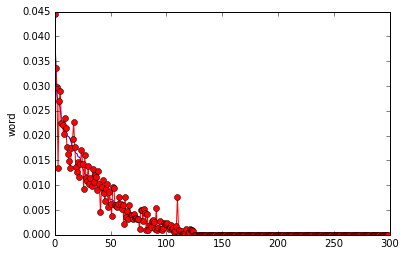

===
4331 4331 0.159723413312 taiwan_loc_|
4327 4328 0.0854238629487 tainan_loc_|
837 839 0.0331977777499 chinese_new_year_other_|
4511 4514 0.0274095489304 tower_block_other_|
1365 1369 0.0260080246753 earthquake_other_|
1543 1548 0.0242481389399 family_other_|
782 788 0.0207455579786 channel_newsasia_org_|
3730 3737 0.0197146651447 richter_magnitude_scale_other_|
2440 2448 0.0186041057556 korean_central_news_agency_other_|
18 27 0.0183060506194 8-bit_other_|
826 836 0.0166777799683 chinese_calendar_other_|
4274 4285 0.0157540696509 survivor_(band)_org_|
2883 2895 0.0154955148519 moment_magnitude_scale_other_|
219 232 0.0152295383059 apartment_other_|
4470 4484 0.014768226693 tin_can_other_|
408 423 0.0142253979387 beam_(structure)_other_|
3594 3610 0.0141746332913 quake_(video_game)_other_|
4312 4329 0.0134762226491 taipei_loc_|
3781 3799 0.0133451537923 rubble_other_|
2641 2660 0.0128308146411 ma_ying-jeou_per_|


In [286]:
kprint = 20
indsmall=[]
for e in ents[:kprint]:
    indsmall.append(ent_ind[e])
indsmall = np.array(indsmall)    
NEsmall = NE[:,indsmall]

kplot=300
e_lex = NE.T.dot(nScore_lex)
e_tri = NE.T.dot(nScore)
N = min(sum(e_lex!=0),sum(e_tri!=0))
print N
eind = e_lex.argsort()[::-1][:kplot]
e_lex_ = np.array([e_lex[k] for k in eind])
e_tri_ = np.array([e_tri[k] for k in eind])

plt.plot(range(len(eind)),e_lex_,'b',e_tri_,'ro-')
#plt.plot(range(len(wind)),np.log(w_lex_),'b',np.log(w_tri_),'r')
plt.ylabel('word')

fig = plt.gcf()
fig.savefig('/home/jwang112/Dropbox/linux_buffer/figs/ent.png',bbox_inches='tight')


e_lex_small = e_lex[indsmall]
e_tri_small = e_tri[indsmall]
eindsmall = e_lex_small.argsort()[::-1]
e_lex_small_ = np.array([e_lex_small[k] for k in eindsmall])
e_tri_small_ = np.array([e_tri_small[k] for k in eindsmall])

rate = e_tri_small_/e_lex_small_
#ate = np.array([w_tri_[k]/w_lex_[k] if w_tri_[k] /w_lex_[k]>1 else w_lex_[k]/w_tri_[k] for k in range(len(w_tri_))])
rind = rate.argsort()[::-1]
for k in rind:    
    #print k,e_tri_small_[k]/e_lex_small_[k],ents[indsmall[eindsmall[k]]][:-2]
    print str(e_tri_small_[k]/e_lex_small_[k]) + '\t'+ents[indsmall[eindsmall[k]]][:-2]
plt.show()
print "==="
i=18
res0 = printRankedEnt(Pw_zs[1][:,i],evocab,20,DISPLAY=True)

In [277]:
list(np.array(ents)[e_lex.argsort()[::-1][0:50]])
#e_tri[18]/e_lex[18]

[u'taiwan_loc_|',
 u'tainan_loc_|',
 u'apartment_other_|',
 u'family_other_|',
 u'tower_block_other_|',
 u'quake_(video_game)_other_|',
 u'city_other_|',
 u'richter_magnitude_scale_other_|',
 u'survivor_(band)_org_|',
 u'earthquake_other_|',
 u'moment_magnitude_scale_other_|',
 u'korean_central_news_agency_other_|',
 u'beam_(structure)_other_|',
 u'8-bit_other_|',
 u'flat-four_engine_other_|',
 u'channel_newsasia_org_|',
 u'building_code_other_|',
 u'2006_hengchun_earthquake_other_|',
 u'rubble_other_|',
 u'reuters_org_|',
 u'chinese_new_year_other_|',
 u'rubble_masonry_other_|',
 u'chinese_calendar_other_|',
 u'cnn_org_|',
 u'rattlesnake_other_|',
 u'storey_other_|',
 u'breathing_other_|',
 u'2011_christchurch_earthquake_other_|',
 u'swarm_behaviour_other_|',
 u'emergency_management_other_|',
 u'strike_action_other_|',
 u'mayor_of_london_other_|',
 u'cigar_other_|',
 u'vietnam_loc_|',
 u'tin_can_other_|',
 u'ministry_(government_department)_other_|',
 u'interior_ministry_other_|',
 u'

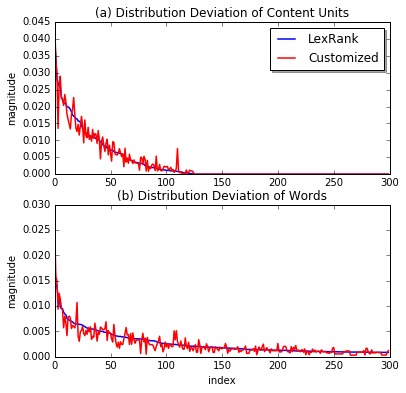

In [289]:
f=plt.figure(1)
f.set_figheight(6)


plt.subplot(211)
l3,l4=plt.plot(range(len(eind)),e_lex_,'b',e_tri_,'r',linewidth=1.5)
#plt.legend((l3, l4), ('LexRank', 'Customized'), loc='upper right', shadow=True)
plt.ylabel('magnitude')
plt.legend((l1, l2), ('LexRank', 'Customized'), loc='upper right', shadow=True)
plt.title('(a) Distribution Deviation of Content Units')

plt.subplot(212)
l1,l2=plt.plot(range(len(wind)),w_lex_,'b',w_tri_,'r',linewidth=1.5)
plt.ylabel('magnitude')
plt.title('(b) Distribution Deviation of Words')
plt.xlabel('index')
fig = plt.gcf()
plt.show()


fig.savefig('/home/jwang112/Dropbox/linux_buffer/figs/ent_word.png',dpi=300,bbox_inches='tight')

In [297]:
printRankedEnt(entsScore,ents,100,DISPLAY=True)

1 1 0.0192752229976 tainan_loc_|
-1 0 0.00933915635563 taiwan_loc_|


{u'tainan_loc_|': 1, u'taiwan_loc_|': -1}